In [ ]:
!pip install matplotlib_venn

In [29]:
import json
import os
from collections import Counter
import requests
import numpy as np
from tqdm import tqdm
from wikidata.client import Client

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib_venn import venn3, venn3_circles
from matplotlib_venn import venn2, venn2_circles

from rdflib import Graph, URIRef, Literal
from rdflib.namespace import OWL, RDFS, XSD

# DISTRIBUTION OF WLS CLAIMS ON TOP 10 PROPERTIES PER DATASET

In [30]:
def req_labels(wiki_id):
    client = Client()           
    entity = client.get(wiki_id, load=True)
    return entity.label.texts['en']

In [31]:
def get_norm(na_dict, depr_dict):
    norm_dict = {}
    for v in na_dict:
        if v not in depr_dict:
            norm_dict.update({v:na_dict[v]})
        else:
            norm_dict.update({v:na_dict[v]-depr_dict[v]})
            
    return norm_dict

In [32]:
def get_json(file_path):
 
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
    dict(list(data.items())[0: 10])
    
    return data

In [56]:
def data_preprocessing(dataset_keyword):

    # all claims count by property
    all_claims = get_json(f'results/properties/{dataset_keyword}.json')

    # all claims with selected qualifier
    qualif = get_json(f'results/otherAnalysis/propertiesQualifiers/{dataset_keyword}.json')
            
    # all claims with deprecated rank
    depr = get_json(f'results/otherAnalysis/propertiesDeprecated/{dataset_keyword}.json')
    
    # all claims with no value
    null = get_json(f'results/blank/{dataset_keyword}.json')
    
    # all non-asserted claims
    na = get_json(f'results/otherAnalysis/propertiesNotAsserted/{dataset_keyword}.json')

    # all non-asserted and with normal rank (non-asserted - deprecated)
    norm = get_norm(na, depr)
    
    # all unknown value claims
    #unknown = get_json(f'results/unknownValue/{dataset_keyword}.json') # TO BE CHANGED
    unknown = get_json(f'results/blank/{dataset_keyword}.json')
    
    # TOP 10 properties for each dataset 
#     null = dict(list(null.items())[0: 10])
#     qualif = dict(list(qualif.items())[0: 10])
#     depr = dict(list(depr.items())[0: 10])
#     norm = dict(list(norm.items())[0: 10])
#     unknown = dict(list(unknown.items())[0: 10])
    
    return all_claims, qualif, depr, null, na, norm, unknown

In [57]:
pop, pop_qualif, pop_depr, pop_null, pop_na, pop_norm, pop_unknown = data_preprocessing('pop')
viz, viz_qualif, viz_depr, viz_null, viz_na, viz_norm, viz_unknown= data_preprocessing('visual')
txt, txt_qualif, txt_depr, txt_null, txt_na, txt_norm, txt_unknown = data_preprocessing('textual')
s, s_qualif, s_depr, s_null, s_na, s_norm, s_unknown = data_preprocessing('stars')
g, g_qualif, g_depr, g_null, g_na, g_norm, g_unknown = data_preprocessing('galaxy')

### Draw the barcharts

In [58]:
def draw_bar(qualif, depr, null, norm, unknown, label):
    temp = {k: qualif.get(k, 0) + depr.get(k, 0) for k in set(qualif) | set(depr)}
    temp1 = {k: temp.get(k, 0) + null.get(k, 0) for k in set(temp) | set(null)}
    temp2 = {k: temp1.get(k, 0) + norm.get(k, 0) for k in set(temp1) | set(norm)}
    temp3 = {k: temp2.get(k, 0) + unknown.get(k, 0) for k in set(temp2) | set(unknown)}


    sortedProperties = sorted(temp3.items(), key=lambda x:x[1], reverse=True)
    converted_dict = dict(sortedProperties[:20])
    
    ns_list_of_tuples,na_list_of_tuples,nv_list_of_tuples, norm_list_of_tuples, unknown_list_of_tuples = [],[],[],[],[]
    
    for x in converted_dict:
        if x in qualif.keys():
            ns_list_of_tuples.append((x,qualif[x]))
        else:
            ns_list_of_tuples.append((x,0))
            
    for x in converted_dict:
        if x in null.keys():
            nv_list_of_tuples.append((x,null[x]))
        else:
            nv_list_of_tuples.append((x,0))
        
    for x in converted_dict:
        if x in depr.keys():
            na_list_of_tuples.append((x,depr[x]))
        else:
            na_list_of_tuples.append((x,0))
            
    for x in converted_dict:
        if x in norm.keys():
            norm_list_of_tuples.append((x,norm[x]))
        else:
            norm_list_of_tuples.append((x,0))
            
    for x in converted_dict:
        if x in unknown.keys():
            unknown_list_of_tuples.append((x,unknown[x]))
        else:
            unknown_list_of_tuples.append((x,0))
    
    l1, l2, l3 = [], [], []
    x = 0
    while x < len(na_list_of_tuples):
        l1.append(int(na_list_of_tuples[x][1] + nv_list_of_tuples[x][1]))
        l2.append(int(na_list_of_tuples[x][1] + nv_list_of_tuples[x][1] + ns_list_of_tuples[x][1]))
        l3.append(int(na_list_of_tuples[x][1] + nv_list_of_tuples[x][1] + ns_list_of_tuples[x][1] + norm_list_of_tuples[x][1]))
        x+=1

    fig, ax = plt.subplots(figsize=(5, 5))
    plt.bar(range(len(na_list_of_tuples)), [na[1] for na in na_list_of_tuples], align='center') 
    plt.bar(range(len(nv_list_of_tuples)), [nv[1] for nv in nv_list_of_tuples], bottom=[na[1] for na in na_list_of_tuples], align='center')
    plt.bar(range(len(ns_list_of_tuples)), [ns[1] for ns in ns_list_of_tuples], bottom=l1, align='center') 
    plt.bar(range(len(norm_list_of_tuples)), [nn[1] for nn in norm_list_of_tuples], bottom=l2, align='center') 
    plt.bar(range(len(unknown_list_of_tuples)), [nu[1] for nu in unknown_list_of_tuples], bottom=l3, align='center') 
    
    #plt.xticks(range(len(labels)), [v for k,v in labels.items()])
    plt.xticks(range(len(na_list_of_tuples)), [na[0] for na in na_list_of_tuples])
    ax.set_title(label)
    ax.set_xlabel('properties')
    plt.xticks(rotation=90)
    plt.yscale('log')
    ax.set_ylabel('occurrences')
    labels_set = ['Non-asserted:Deprecated', 'Null-valued', 'WLS qualified','Non-asserted:Normal', 'Unknown-valued']
    plt.legend(labels_set,loc=1)
    #plt.show()
    return plt

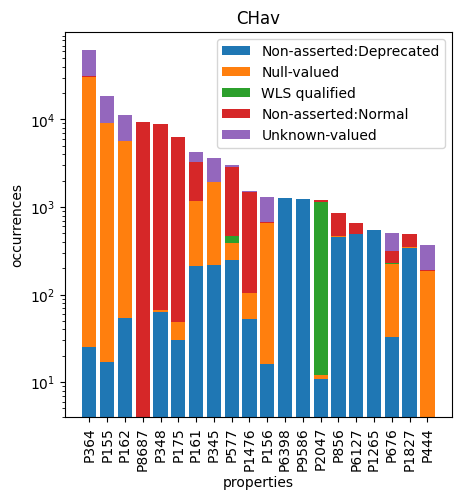

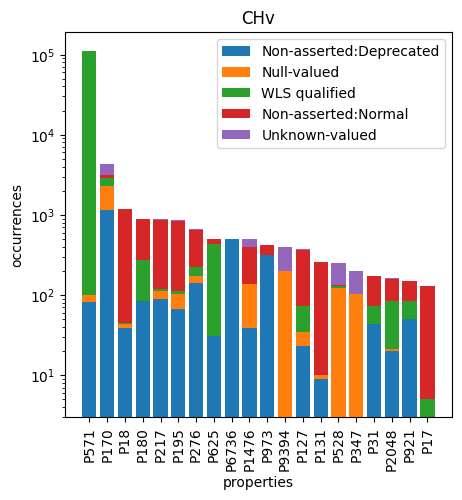

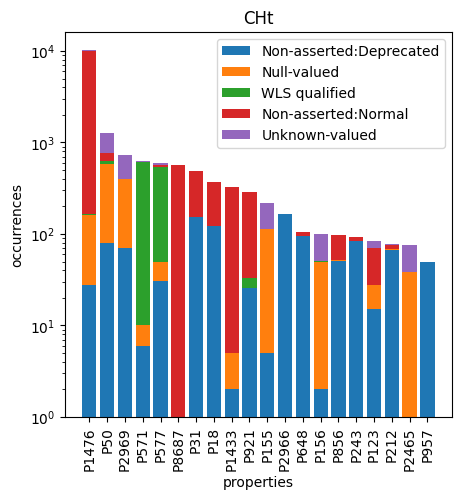

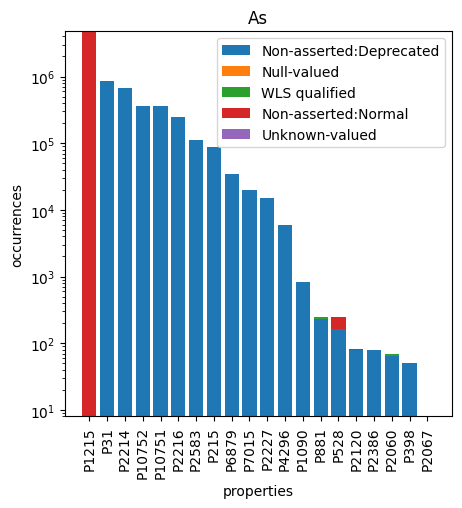

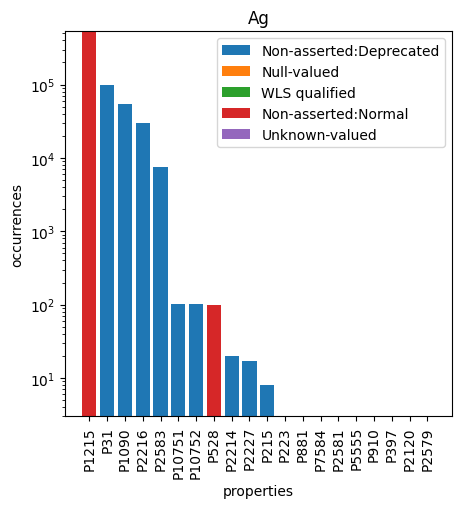

In [59]:
pop_bar = draw_bar(pop_qualif, pop_depr, pop_null, pop_norm, pop_unknown, 'CHav')
viz_bar = draw_bar(viz_qualif, viz_depr, viz_null, viz_norm, viz_unknown, 'CHv')
txt_bar = draw_bar(txt_qualif, txt_depr, txt_null, txt_norm, txt_unknown, 'CHt')
s_bar = draw_bar(s_qualif, s_depr, s_null, s_norm, s_unknown, 'As')
g_bar = draw_bar(g_qualif, g_depr, g_null, g_norm, g_unknown, 'Ag')

# QUALIFIERS ANALYSIS

### Overview in the whole Wikidata

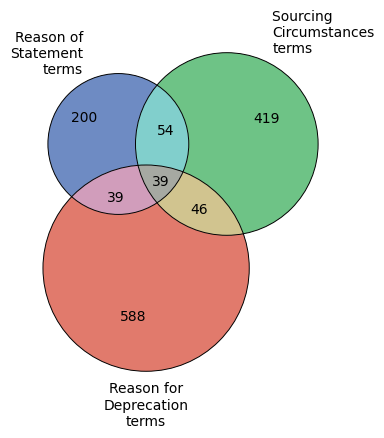

In [13]:
all_natures = ["Q202","Q404","Q795","Q5151","Q7560","Q7565","Q7727","Q8253","Q9134","Q9826","Q10737","Q11574","Q27058","Q29485","Q30612","Q34651","Q35102","Q41719","Q43115","Q44342","Q48890","Q53815","Q61002","Q69883","Q82821","Q101072","Q101244","Q102786","Q108163","Q127843","Q128758","Q129580","Q130601","Q131138","Q131288","Q132050","Q132555","Q137816","Q139060","Q144552","Q146786","Q170028","Q170393","Q170539","Q170584","Q171558","Q174779","Q179226","Q180472","Q188224","Q188577","Q188863","Q189539","Q191062","Q201676","Q202785","Q209896","Q215071","Q217102","Q222749","Q226593","Q230768","Q280943","Q311290","Q311624","Q318028","Q319141","Q331483","Q340117","Q357662","Q363802","Q367293","Q464980","Q502918","Q506461","Q517361","Q548320","Q580750","Q593147","Q603908","Q663208","Q682721","Q693726","Q701040","Q706848","Q707482","Q712144","Q720243","Q734271","Q734818","Q744069","Q748250","Q751826","Q774228","Q791801","Q797551","Q811683","Q841440","Q842346","Q855395","Q873222","Q877353","Q880643","Q927079","Q965330","Q987080","Q1069127","Q1079023","Q1125292","Q1193907","Q1199948","Q1219996","Q1236807","Q1255828","Q1306755","Q1309409","Q1321906","Q1362939","Q1370468","Q1395509","Q1520777","Q1614475","Q1630279","Q1727855","Q1784021","Q2101564","Q2254471","Q2379266","Q2500107","Q2568454","Q2631864","Q2796622","Q2839009","Q2842604","Q2969701","Q3089219","Q3144351","Q3250324","Q3281534","Q3343293","Q3422045","Q3491297","Q3497659","Q3504856","Q3544030","Q3604747","Q3620816","Q3739104","Q3739281","Q3840054","Q3918409","Q4019680","Q4676846","Q4695151","Q4736562","Q4895105","Q4917105","Q5049737","Q5049740","Q5116937","Q5135520","Q5358065","Q5615122","Q5727902","Q5994320","Q6136054","Q7458534","Q7603672","Q9695616","Q10300821","Q10348044","Q10556182","Q10578722","Q10585806","Q11146759","Q11734477","Q11999895","Q13100823","Q13579947","Q13649246","Q15104814","Q15306849","Q15632617","Q15893266","Q15989253","Q16571590","Q16582801","Q16969608","Q17024293","Q17075652","Q17125229","Q17125668","Q17776250","Q18028810","Q18122778","Q18603603","Q18603648","Q18706315","Q18912752","Q19357312","Q105078430","Q105083598","Q105223969","Q105334701","Q105564935","Q106399770","Q106466760","Q106708740","Q106708760","Q107036510","Q107217620","Q107356532","Q107380060","Q108584722","Q110143752","Q110290991","Q110290992","Q110418529","Q110781369","Q110825039","Q111014860","Q111291995","Q111305333","Q112627455","Q112883215","Q113326371","Q114875425","Q114980101","Q115211583","Q115455199","Q115471214","Q115630159","Q19953632","Q20734200","Q21514702","Q21818619","Q22979588","Q23013246","Q24025284","Q24238356","Q24575125","Q24777666","Q25895909","Q26932615","Q27136782","Q27943030","Q28831311","Q28962310","Q28962312","Q29023906","Q29509043","Q29509080","Q29569274","Q30108381","Q30230067","Q30232378","Q30278109","Q30889518","Q32188232","Q35779580","Q37113960","Q38131096","Q39811647","Q39894595","Q40719727","Q40719766","Q42590222","Q44601380","Q45025362","Q45123627","Q45406573","Q47001369","Q47035128","Q47165448","Q50095342","Q50376823","Q52834024","Q53737447","Q54835811","Q54943392","Q55093533","Q55097243","Q55713864","Q55909176","Q55935272","Q55935291","Q56557591","Q56644435","Q59237924","Q59496158","Q59864995","Q60070514","Q60614352","Q61029267","Q63971158","Q64447881","Q64467983","Q64473030","Q64643615","Q64728694","Q64760153","Q66814106","Q66814160","Q66814170","Q66814185","Q66814186","Q68575046","Q70650920","Q70918737","Q71536081","Q72842928","Q73290844","Q74524855","Q76500861","Q79030196","Q80122004","Q83489981","Q84590041","Q90177495","Q91013007","Q96102813","Q96102817","Q96943145","Q97161074","Q97284968","Q98034328","Q98047140","Q100349848","Q101437313","Q102129428","Q104378399","Q104603903"]
all_sourcing = ["Q110","Q263","Q328","Q578","Q638","Q659","Q679","Q866","Q871","Q1087","Q1661","Q1995","Q2048","Q2075","Q2087","Q2165","Q2173","Q2429","Q2436","Q2506","Q2644","Q2652","Q5151","Q5294","Q5302","Q5332","Q5435","Q5500","Q5546","Q6124","Q6126","Q6151","Q6284","Q6327","Q6380","Q6482","Q6528","Q6556","Q6628","Q6634","Q6638","Q6644","Q6679","Q6695","Q6704","Q6801","Q6815","Q6865","Q6875","Q6889","Q6932","Q6957","Q6958","Q7001","Q7006","Q7034","Q7049","Q7061","Q7063","Q7278","Q7585","Q7587","Q7589","Q7600","Q7619","Q7621","Q7627","Q7646","Q7656","Q7669","Q7672","Q7678","Q7683","Q7708","Q7716","Q7773","Q7775","Q7806","Q7831","Q8083","Q8095","Q8436","Q8447","Q8449","Q8454","Q8486","Q9492","Q9510","Q10737","Q10791","Q11081","Q11169","Q11184","Q11629","Q12138","Q12202","Q17949","Q18452","Q18577","Q18623","Q18645","Q18787","Q19301","Q19342","Q19440","Q19677","Q19750","Q23445","Q23458","Q23482","Q23563","Q23806","Q24860","Q25337","Q25641","Q27058","Q29485","Q29992","Q30388","Q30470","Q30544","Q31834","Q32032","Q32129","Q32524","Q32548","Q34302","Q34902","Q35856","Q36192","Q36424","Q36578","Q37038","Q39503","Q39911","Q41176","Q41719","Q43812","Q44342","Q45594","Q47770","Q48183","Q48528","Q49180","Q58251","Q73368","Q75634","Q76666","Q79007","Q81336","Q82821","Q102145","Q108709","Q131482","Q132382","Q132555","Q134032","Q134550","Q134762","Q141212","Q143636","Q149086","Q155656","Q157031","Q159334","Q159979","Q166735","Q167037","Q167270","Q170028","Q170393","Q170584","Q178651","Q178671","Q180494","Q185049","Q185688","Q186081","Q188236","Q188572","Q189021","Q189539","Q189643","Q191360","Q191891","Q192003","Q192613","Q199700","Q200125","Q201413","Q201676","Q202785","Q203443","Q204854","Q207315","Q214267","Q214796","Q216169","Q221725","Q224952","Q230768","Q231158","Q249405","Q273570","Q280658","Q308678","Q309100","Q319141","Q320441","Q336289","Q344495","Q357662","Q363948","Q367293","Q380559","Q384003","Q387827","Q388505","Q408386","Q460797","Q472658","Q475476","Q484284","Q506461","Q529711","Q535116","Q580922","Q603908","Q620225","Q629369","Q665247","Q678116","Q689141","Q693726","Q708653","Q712144","Q716894","Q722040","Q731126","Q734832","Q739302","Q748250","Q750663","Q777717","Q780605","Q791801","Q814441","Q820655","Q827597","Q830396","Q840148","Q847956","Q900584","Q965330","Q1050305","Q1056165","Q1125921","Q1130275","Q1145106","Q1156791","Q1156877","Q1193907","Q1229261","Q1231640","Q1232589","Q1235185","Q1236807","Q1240711","Q1255828","Q1266283","Q1297822","Q1322263","Q1332286","Q1349417","Q1361758","Q1366722","Q1373131","Q1385033","Q1395509","Q1420342","Q1423364","Q1434353","Q1440453","Q1464916","Q1466128","Q1479943","Q1520777","Q1543700","Q1639895","Q1640824","Q1681122","Q1729626","Q1747689","Q1762010","Q1939539","Q1986893","Q2132119","Q2296856","Q2339007","Q2344557","Q2389905","Q2478058","Q2492572","Q2496920","Q2534525","Q2571972","Q2657718","Q2796622","Q2821778","Q2914547","Q2919270","Q2920228","Q3061727","Q3324507","Q3364142","Q3373417","Q3509975","Q3544030","Q3663963","Q3689649","Q3704134","Q3739104","Q3749265","Q3752578","Q3776956","Q3847033","Q3962655","Q3984452","Q4010330","Q4368793","Q4401039","Q4676846","Q4895105","Q4941597","Q4994089","Q5287678","Q5297327","Q5432619","Q5727902","Q5896941","Q6136054","Q6692036","Q6878417","Q7309433","Q7585771","Q7777001","Q7882489","Q10082670","Q10578722","Q10585806","Q10677698","Q11060274","Q11086567","Q11553006","Q11564351","Q12158205","Q12300489","Q12628598","Q12772819","Q12779928","Q12827256","Q13026105","Q13050613","Q13053626","Q13634809","Q13649246","Q13780930","Q14897293","Q14903979","Q14946528","Q15051339","Q15312935","Q15729048","Q15989253","Q16189205","Q16364045","Q16368443","Q16571590","Q16693773","Q16775580","Q16868120","Q16886573","Q17125668","Q17145888","Q17152495","Q17300027","Q17373699","Q17525443","Q17584242","Q17781833","Q17853087","Q18122778","Q18195782","Q18443153","Q18603603","Q18706315","Q18912752","Q19269277","Q19426560","Q19860854","Q20204892","Q20631656","Q20734200","Q20820271","Q21042816","Q21091870","Q21096955","Q21097017","Q21097088","Q21655367","Q21683367","Q21818619","Q22812948","Q22979588","Q23013246","Q24097670","Q24575110","Q24575125","Q25328680","Q25858158","Q25895909","Q26162470","Q26877139","Q26877143","Q26907166","Q26932615","Q26944781","Q26961029","Q27055432","Q27132179","Q27145860","Q27926527","Q27965041","Q28831311","Q28962310","Q28962312","Q29023906","Q29509043","Q29509080","Q29940705","Q29998666","Q30108381","Q30230067","Q30349628","Q31275158","Q31777238","Q31884622","Q31888178","Q31888506","Q32188232","Q33853983","Q35779580","Q35946093","Q35966949","Q37113960","Q38173183","Q39811647","Q39893449","Q40422607","Q40690303","Q40719662","Q40719687","Q40719707","Q40719727","Q40719748","Q40719766","Q41696231","Q41755623","Q42727519","Q45406573","Q47035128","Q47150325","Q47546524","Q47851538","Q50095342","Q50376823","Q50843747","Q51367591","Q52008295","Q52834024","Q54418095","Q54806642","Q54835811","Q54836621","Q54943392","Q54975531","Q55235315","Q55286710","Q55935272","Q55935291","Q56295925","Q56557591","Q56580316","Q56644435","Q56685043","Q58446147","Q59564754","Q59608653","Q59783740","Q59827273","Q59864995","Q60070514","Q60503972","Q61474911","Q61793245","Q65088633","Q65706647","Q68575046","Q69652283","Q69652498","Q70650920","Q70918737","Q71533031","Q71536040","Q71536244","Q73290844","Q77066609","Q79030196","Q79030284","Q82069695","Q84423633","Q84761689","Q86454040","Q97107245","Q98344233","Q99507087","Q99773469","Q100256464","Q100349848","Q101143128","Q104378399","Q104582646","Q105483554","Q105642994","Q105675146","Q105769095","Q106160493","Q106372020","Q106419137","Q107356532","Q108172170","Q109012782","Q109104929","Q110143752","Q110290991","Q110290992","Q110558700","Q111524327","Q111524824","Q112167505","Q112249200","Q112980637","Q113292851","Q114369323","Q114786547","Q115455199","Q115464513","Q115473624"]
all_deprReason = ["Q30","Q145","Q290","Q344","Q404","Q958","Q4006","Q8192","Q8253","Q8777","Q9143","Q11184","Q11471","Q12136","Q12271","Q16346","Q17451","Q17949","Q18535","Q20357","Q27058","Q29485","Q32635","Q32993","Q33999","Q34302","Q35059","Q41719","Q42253","Q43091","Q44342","Q44497","Q48183","Q48422","Q49614","Q49836","Q56061","Q61002","Q79782","Q83900","Q93190","Q101072","Q110874","Q122192","Q125191","Q127843","Q128758","Q131138","Q132382","Q132555","Q133182","Q140641","Q152074","Q152478","Q152869","Q154242","Q156223","Q160843","Q164666","Q170028","Q174923","Q179550","Q180472","Q180711","Q181970","Q186982","Q189203","Q189349","Q190084","Q190586","Q192184","Q194189","Q203443","Q204854","Q208099","Q208826","Q210392","Q213388","Q214866","Q217102","Q217743","Q230671","Q230768","Q231835","Q272035","Q280943","Q282744","Q305418","Q308859","Q309314","Q309901","Q311463","Q319596","Q325026","Q327000","Q331483","Q334640","Q337690","Q355364","Q363948","Q410555","Q452440","Q464858","Q473432","Q476697","Q483454","Q483677","Q502918","Q506319","Q517361","Q519875","Q545779","Q557945","Q559618","Q560361","Q567555","Q570730","Q574433","Q587972","Q600499","Q610241","Q614232","Q631331","Q643290","Q647578","Q680007","Q680042","Q685744","Q693988","Q696606","Q721747","Q728937","Q734832","Q748250","Q759734","Q759815","Q776167","Q789984","Q791801","Q796919","Q811683","Q826949","Q827597","Q844326","Q846574","Q851176","Q854479","Q858082","Q862581","Q877353","Q878352","Q879295","Q880643","Q910845","Q929804","Q998790","Q1043452","Q1045481","Q1052281","Q1064904","Q1066717","Q1071027","Q1085588","Q1121708","Q1129622","Q1136723","Q1138586","Q1140419","Q1145106","Q1150070","Q1171224","Q1185297","Q1188533","Q1193907","Q1207505","Q1210382","Q1229261","Q1229735","Q1232589","Q1236807","Q1250718","Q1251417","Q1260827","Q1263068","Q1309976","Q1332286","Q1338119","Q1348305","Q1350108","Q1363768","Q1371427","Q1371586","Q1376796","Q1384499","Q1395509","Q1395577","Q1416898","Q1454489","Q1454723","Q1471017","Q1571900","Q1630279","Q1648389","Q1673271","Q1682108","Q1735821","Q1743028","Q1751943","Q1753979","Q1813536","Q1898510","Q1917420","Q1922815","Q1938536","Q1979154","Q1984758","Q2015967","Q2051704","Q2063516","Q2085518","Q2090618","Q2166722","Q2221906","Q2301707","Q2343619","Q2356726","Q2389905","Q2449404","Q2454100","Q2478058","Q2478595","Q2491016","Q2492572","Q2496920","Q2503234","Q2511187","Q2720909","Q2727213","Q2796622","Q2908560","Q2918584","Q2920228","Q2999003","Q3076763","Q3104453","Q3112030","Q3149768","Q3242304","Q3248417","Q3343293","Q3348519","Q3352817","Q3444685","Q3467464","Q3544030","Q3575478","Q3732575","Q3739281","Q3769186","Q3813865","Q3847033","Q3877969","Q3918409","Q3962655","Q4115113","Q4119183","Q4167410","Q4388326","Q4503801","Q4590027","Q4663389","Q4691861","Q4925193","Q5015649","Q5131849","Q5135520","Q5165085","Q5193258","Q5253643","Q5282797","Q5289816","Q5420623","Q5428139","Q5432619","Q5432682","Q5439369","Q5727902","Q5909236","Q5993036","Q6022092","Q6136054","Q6428674","Q6875856","Q7200789","Q7219623","Q7234480","Q7299951","Q7318524","Q7712947","Q7833925","Q7885121","Q7958155","Q8143062","Q10357784","Q10418049","Q11381163","Q11486291","Q11486300","Q11631567","Q11639308","Q12040628","Q12139592","Q12139612","Q12257711","Q12377751","Q12769393","Q12780996","Q13002315","Q13168732","Q13579947","Q13634247","Q13649246","Q14514600","Q14820227","Q14946528","Q15239622","Q15632617","Q15634554","Q15635173","Q15893266","Q15989253","Q16571590","Q16868120","Q16879044","Q16886573","Q17013103","Q17024293","Q17055519","Q17276484","Q17334923","Q17362920","Q17538709","Q17853087","Q18089644","Q18195782","Q18411409","Q18511800","Q18603603","Q18603731","Q18644427","Q18674452","Q18748141","Q18912752","Q19357621","Q19404626","Q19778981","Q19801088","Q19860854","Q20734200","Q20830903","Q20990956","Q21096955","Q21097017","Q21097088","Q21124171","Q21152551","Q21175641","Q21262209","Q21441764","Q21469979","Q21486105","Q21502838","Q21514702","Q21522908","Q21557777","Q21655367","Q21683863","Q21701659","Q21848415","Q21887121","Q21996602","Q22039296","Q22296213","Q22674925","Q22712824","Q22979588","Q23005333","Q23009439","Q23077442","Q23090331","Q24037741","Q24238356","Q24629887","Q25054195","Q25235916","Q25345174","Q25391834","Q25397937","Q25796498","Q25810847","Q25895909","Q26162470","Q26256296","Q26262236","Q26944781","Q27055388","Q27229605","Q27921563","Q27949697","Q27988255","Q28091153","Q28370743","Q28831311","Q28846358","Q28874503","Q28962312","Q29168209","Q29509080","Q29569274","Q29863201","Q29933798","Q29998666","Q30014662","Q30108381","Q30126155","Q30349290","Q30580660","Q35145263","Q35647389","Q35773207","Q35779580","Q35966949","Q37113960","Q39811647","Q39894595","Q39911916","Q41755623","Q41787617","Q42097313","Q42415624","Q42696902","Q42727519","Q44374960","Q45025362","Q45157076","Q45403344","Q45887982","Q47496130","Q48233543","Q49932764","Q50376823","Q50379085","Q51734763","Q51845721","Q51884830","Q51921823","Q51984269","Q52679949","Q53710082","Q54554025","Q54767019","Q54806642","Q54943392","Q54975531","Q54976355","Q55107540","Q55193796","Q55570340","Q56631052","Q56998693","Q57195384","Q57495609","Q58007288","Q58370623","Q58439442","Q58839938","Q59016370","Q59237924","Q59245870","Q59550254","Q59555084","Q59864995","Q60021722","Q60311385","Q60457486","Q61003021","Q61475894","Q61915880","Q62024811","Q62091220","Q62391983","Q62606058","Q63065035","Q63077779","Q64445414","Q64728500","Q64728693","Q64728694","Q64737957","Q65016715","Q65088633","Q65560376","Q65706543","Q65948447","Q66107668","Q66439731","Q66475652","Q66547754","Q67125514","Q67203058","Q67932942","Q68648103","Q70390311","Q70392051","Q70650920","Q70918737","Q71533355","Q71535331","Q71536040","Q71536244","Q71538638","Q71887839","Q72951433","Q73290844","Q73545549","Q74524855","Q74557669","Q75173816","Q75209826","Q75801665","Q76449977","Q76453668","Q76500861","Q76761345","Q77253277","Q77980264","Q78156572","Q78694451","Q80122004","Q80657659","Q80833195","Q80996755","Q80997055","Q81068910","Q82549269","Q83371408","Q84590041","Q86191979","Q87346598","Q87406427","Q87479384","Q87524790","Q87723111","Q87772960","Q88903067","Q89031984","Q89317853","Q89665509","Q89904285","Q90177495","Q91135299","Q91778853","Q91778954","Q92056121","Q93955709","Q94601911","Q95677783","Q95968315","Q95987004","Q96086516","Q96191913","Q96242333","Q97107245","Q97339959","Q97445863","Q97479954","Q98034328","Q98052232","Q98271705","Q98386534","Q98398200","Q98523542","Q98537072","Q99460987","Q99496317","Q99539439","Q99562365","Q99572267","Q99949087","Q99976017","Q100148250","Q100331739","Q100700854","Q100701259","Q101029366","Q101076817","Q103598308","Q103598309","Q103598310","Q103864591","Q103875254","Q104029445","Q104127786","Q104172943","Q104245838","Q104255002","Q104378399","Q104602651","Q104653273","Q104671559","Q104976733","Q105076526","Q105223969","Q105631494","Q105675146","Q105709687","Q105773155","Q105812742","Q105827064","Q105980786","Q106626749","Q106651934","Q106795737","Q106849510","Q106860610","Q106866757","Q106980928","Q107028274","Q107037229","Q107214772","Q107228472","Q107269364","Q107278014","Q107345922","Q107348938","Q107356532","Q107366274","Q107379991","Q107410318","Q107631537","Q107631600","Q107710355","Q107724711","Q107936414","Q108028808","Q108172170","Q108180274","Q108281296","Q108385350","Q108429588","Q108429590","Q108630154","Q108683974","Q108743139","Q108895441","Q109290665","Q109324480","Q109352971","Q109659893","Q109667022","Q110161795","Q110208058","Q110492913","Q110643252","Q110646418","Q110678154","Q110723780","Q110770329","Q111019038","Q111043064","Q111083433","Q111149276","Q111189544","Q111253654","Q111303008","Q111360696","Q111383754","Q111472389","Q111678745","Q111678787","Q112181004","Q112219947","Q112226262","Q112309110","Q112341165","Q112619903","Q112621540","Q112624709","Q112669418","Q112930606","Q112943271","Q112943275","Q113202767","Q113319997","Q113358113","Q113359274","Q113360982","Q113485150","Q113547919","Q113558184","Q113570178","Q113623390","Q113704132","Q113930396","Q113989762","Q114239895","Q114342413","Q114401995","Q114713247","Q115045024","Q115099570","Q115323571"]

out = venn3([set(all_natures), set(all_sourcing), set(all_deprReason)],
      set_colors=('#3E64AF', '#3EAF5D', '#D74E3B'), 
      set_labels = ('Reason of\nStatement\nterms', 
                    'Sourcing \nCircumstances\nterms',
                    'Reason for\nDeprecation\nterms'),
      alpha=0.75)
venn3_circles([set(all_natures), set(all_sourcing), set(all_deprReason)], lw=0.7)

for text in out.set_labels:
    text.set_fontsize(10)

plt.show()

### Set intersections

In [14]:
natures_sourcing = set(all_natures).intersection(set(all_sourcing))
deprReason_sourcing = set(all_deprReason).intersection(set(all_sourcing))
natures_deprReason = set(all_natures).intersection(set(all_deprReason))

### Nature of statements and sourcing circumstances in CH data

From a selection of "uncertain" or "false" or "debated" terms for P1502 and P1480 produces a dictionary (all_terms_labels) storing all terms with their labels

54
73


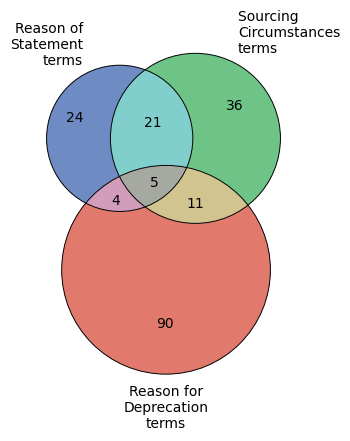

In [15]:
natures_count = {"Q27058": 0, "Q41719": 0, "Q11169": 0, "Q29485": 0, "Q357662": 0, "Q603908": 0, "Q280943": 0, "Q701040": 0, "Q873222": 0, "Q880643": 0, "Q1255828": 0, "Q3918409": 0, "Q13649246": 0, "Q17024293": 0, "Q18603603": 0, "Q18122778": 0, "Q18912752": 0, "Q25895909": 0, "Q24238356": 0, "Q24025284": 0, "Q20734200": 0, "Q26932615": 0, "Q28831311": 0, "Q28962310": 0, "Q28962312": 0, "Q29509080": 0, "Q30230067": 0, "Q30108381": 0, "Q37113960": 0, "Q45025362": 0, "Q38131096": 0, "Q50376823": 0, "Q56644435": 0, "Q54943392": 0, "Q59864995": 0, "Q73290844": 0, "Q74524855": 0, "Q84590041": 0, "Q97161074": 0, "Q100349848": 0, "Q104378399": 0, "Q107217620": 0, "Q106466760": 0, "Q107356532": 0, "Q110143752": 0, "Q110290991": 0, "Q108163": 0, "Q5727902": 0, "Q4895105": 0, "Q744069": 0, "Q748250": 0, "Q21818619": 0, "Q6136054": 0, "Q32188232": 0}
sourcing_count = {'Q9492':0,'Q11169':0,'Q27058':0,'Q17949':0,'Q41719':0,'Q224952':0, 'Q344495':0,'Q319141':0,'Q363948':0,'Q2478058':0,'Q2496920':0,'Q1434353':0,'Q1255828':0,'Q840148':0,'Q791801':0,'Q748250':0,'Q5432619':0,'Q5727902':0,'Q3984452':0,'Q3847033':0,'Q6878417':0,'Q7882489':0,'Q13649246':0,'Q18122778':0,'Q16868120':0,'Q16886573':0,'Q18603603':0,'Q18706315':0,'Q18912752':0,'Q21097017':0,'Q21655367':0,'Q21097088':0,'Q21683367':0,'Q22979588':0,'Q26932615':0,'Q25895909':0,'Q26162470':0,'Q26877139':0,'Q28962310':0,'Q28962312':0,'Q29998666':0,'Q28831311':0,'Q27055432':0,'Q28831311':0,'Q30230067':0,'Q30108381':0,'Q32188232':0,'Q37113960':0,'Q35779580':0,'Q41755623':0,'Q50376823':0,'Q54975531':0,'Q56644435':0,'Q59783740':0,'Q56685043':0,'Q60070514':0,'Q65088633':0,'Q73290844':0,'Q77066609':0,'Q70650920':0,'Q105675146':0,'Q86454040':0,'Q100349848':0,'Q104378399':0,'Q105769095':0,'Q109012782':0,'Q109104929':0,'Q110558700':0,'Q112980637':0,'Q110143752':0,'Q106160493':0,'Q107356532':0,'Q2132119':0,'Q900584':0}

reasons = ['Q48233543', 'Q7885121', 'Q78694451', 'Q65697924', 'Q23009439', 'Q106980928', 'Q734832', 'Q107356532', 'Q7299951', 'Q189203', 'Q19357621', 'Q58439442', 'Q106626749', 'Q517361', 'Q28831311', 'Q45025362', 'Q49614', 'Q21096955', 'Q1263068', 'Q5253643', 'Q72951433', 'Q54976355', 'Q80122004', 'Q16886573', 'Q87772960', 'Q107379991', 'Q60311385', 'Q3962655', 'Q105675146', 'Q1395509', 'Q25895909', 'Q2492572', 'Q1350108', 'Q22979588', 'Q14946528', 'Q94601911', 'Q89904285', 'Q41755623', 'Q99496317', 'Q30014662', 'Q103875254', 'Q29569274', 'Q29485', 'Q76449977', 'Q25345174', 'Q26162470', 'Q29509080', 'Q64445414', 'Q363948', 'Q4115113', 'Q54554025', 'Q98523542', 'Q37113960', 'Q1384499', 'Q44374960', 'Q1236807', 'Q59237924', 'Q1193907', 'Q7318524', 'Q854479', 'Q108630154', 'Q67125514', 'Q45403344', 'Q18674452', 'Q502918', 'Q54806642', 'Q54975531', 'Q27988255', 'Q862581', 'Q2496920', 'Q90177495', 'Q23090331', 'Q15893266', 'Q7234480', 'Q51845721', 'Q647578', 'Q189349', 'Q21441764', 'Q27229605', 'Q65948447', 'Q42727519', 'Q42415624', 'Q28091153', 'Q5432682', 'Q84590041', 'Q26944781', 'Q41719', 'Q12040628', 'Q8143062', 'Q87346598', 'Q35779580', 'Q21262209', 'Q108772390', 'Q35773207', 'Q105773155', 'Q21655367', 'Q1751943', 'Q81068910', 'Q26256296', 'Q108281296', 'Q92056121', 'Q61475894', 'Q109667022', 'Q96191913', 'Q29998666', 'Q104127786', 'Q86191979', 'Q28846358', 'Q62606058', 'Q208219']

print(len(natures_count))
print(len(sourcing_count))

all_terms = set(sourcing_count) | set(natures_count)
all_terms_count = {x:0 for x in all_terms}

all_terms_labels = {}

client = Client() 
for term in all_terms_count:
    try:
        entity = client.get(term, load=True)
        #print(term, entity.label.texts['en'])
        all_terms_labels.update({term:entity.label.texts['en']})
    except:
        print('error', term)
        

out = venn3([set(list(natures_count)), set(list(sourcing_count)), set(reasons)],
      set_colors=('#3E64AF', '#3EAF5D', '#D74E3B'), 
      set_labels = ('Reason of\nStatement\nterms', 
                    'Sourcing \nCircumstances\nterms',
                    'Reason for\nDeprecation\nterms'),
      alpha=0.75)
venn3_circles([set(natures_count), set(sourcing_count), set(reasons)], lw=0.7)

for text in out.set_labels:
    text.set_fontsize(10)

plt.show()